# Basic Classification: Herkunft vorhersagen

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

## Dateset
### Daten herunterladen und in ein Dataframe speichern

In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### Daten säubern

Zeilen mit leeren Felder löschen.

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
dataset = dataset.dropna()

Die `"Origin"` Spalte ist eigentlich categorical und nicht Numerisch. Dies müssen wir umbauen.


In [8]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [9]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Aufteilen der Daten in Train und Test
Nun teilen wir den Datensatz in einen Trainingssatz und einen Testsatz auf.

Wir werden den Testsatz bei der Endauswertung unserer Modelle verwenden.

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Features von Labels trennen

Trennen Sie den Zielwert, das "Label", von den Features. Dieses Label ist der Wert, auf dessen Vorhersage Sie das Modell trainieren werden.

In [11]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features[['USA', 'Europe', 'Japan']].copy()
test_labels = test_features[['USA', 'Europe', 'Japan']].copy()

# Länder aus dem Training/Test features entfernen
train_features = train_features.drop(['USA', 'Europe', 'Japan'], axis=1)
test_features = test_features.drop(['USA', 'Europe', 'Japan'], axis=1)

In [12]:
print(f'Shape of train data: {train_features.shape}')
print(f'Shape of test data: {test_features.shape}')
print(f'Shape of train labels: {train_labels.shape}')
print(f'Shape of test labels: {test_labels.shape}')

Shape of train data: (314, 7)
Shape of test data: (78, 7)
Shape of train labels: (314, 3)
Shape of test labels: (78, 3)


In [13]:
train_features.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
146,28.0,4,90.0,75.0,2125.0,14.5,74
282,22.3,4,140.0,88.0,2890.0,17.3,79
69,12.0,8,350.0,160.0,4456.0,13.5,72
378,38.0,4,105.0,63.0,2125.0,14.7,82
331,33.8,4,97.0,67.0,2145.0,18.0,80


In [14]:
train_labels.head()

,USA,Europe,Japan
146,1,0,0
282,1,0,0
69,1,0,0
378,1,0,0
331,0,0,1


## Lineare Klassifikation

### Eine Variable


Das Training eines Modells mit `tf.keras` beginnt typischerweise mit der Definition der Modellarchitektur.

In diesem Fall verwenden Sie ein Sequentielles Modell. Dieses Modell stellt eine Abfolge von Schritten dar. In diesem Fall gibt es zwei Schritte:

* Normalisierung der eingegebenen `horsepower`.
* Wenden Sie eine lineare Transformation ($y = mx+b$) an, um 3 Ausgaben unter Verwendung von `layers.Dense` zu erzeugen.
* Erzeugen Sie mithilfe der Softmax Funktion die Wahrscheinlichkeiten für den Ursprung des Autos

Zuerst den horsepower `Normalization` layer:

In [15]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

### Model

In [16]:
horsepower_model = Sequential()
horsepower_model.add(horsepower_normalizer)
horsepower_model.add(Dense(units=3, activation='softmax'))

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 3)                 6         
Total params: 9
Trainable params: 6
Non-trainable params: 3
_________________________________________________________________


Dieses Modell wird `Origin` aus `Horsepower` vorhersagen.

Lassen Sie das untrainierte Modell mit den ersten 10 Pferdestärkenwerten laufen. Das Ergebnis wird nicht gut sein, aber Sie werden sehen, dass es die erwartete Form `(10,3)` hat:

In [17]:
horsepower_model.predict(horsepower[:10])

array([[0.145, 0.293, 0.561],
       [0.216, 0.321, 0.463],
       [0.738, 0.202, 0.061],
       [0.097, 0.259, 0.644],
       [0.111, 0.271, 0.618],
       [0.228, 0.324, 0.448],
       [0.087, 0.25 , 0.663],
       [0.111, 0.271, 0.618],
       [0.261, 0.33 , 0.409],
       [0.216, 0.321, 0.463]], dtype=float32)

### Model trainieren

In [18]:
opt_adam = Adam(learning_rate=0.1)
horsepower_model.compile(
    optimizer=opt_adam,
    loss=categorical_crossentropy,
    metrics=['categorical_accuracy'])

Sobald das Training konfiguriert ist, verwenden Sie Model.fit(), um das Training auszuführen:

In [19]:
history = horsepower_model.fit(
    train_features['Horsepower'], 
    train_labels,
    epochs=100,
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 0s 18ms/step - loss: 0.8607 - categorical_accuracy: 0.6335 - val_loss: 0.8109 - val_categorical_accuracy: 0.5873
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 0.7612 - categorical_accuracy: 0.6494 - val_loss: 0.8405 - val_categorical_accuracy: 0.6032
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 0.7583 - categorical_accuracy: 0.6733 - val_loss: 0.8614 - val_categorical_accuracy: 0.5714
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 0.7485 - categorical_accuracy: 0.6932 - val_loss: 0.8298 - val_categorical_accuracy: 0.5714
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 0.7476 - categorical_accuracy: 0.6574 - val_loss: 0.8210 - val_categorical_accuracy: 0.6190
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 0.7454 - categorical_accuracy: 0.6574 - val_loss: 0.8399 - val_categorical_accuracy: 0.6190
Epoch 7/100
8/8 [====

### Evaluation - Wie ist das Training verlaufen?

In [20]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlim([-1, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Origin]')
  plt.legend()
  plt.grid(True)

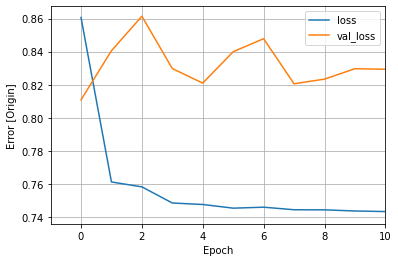

In [21]:
plot_loss(history)

In [22]:
def plot_accuracy(history):
  plt.plot(history.history['categorical_accuracy'], label='accuracy')
  plt.plot(history.history['val_categorical_accuracy'], label='val_accuracy')
  plt.xlim([-1, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy [Origin]')
  plt.legend()
  plt.grid(True)

Da es sich um eine Regression mit einer einzigen Variable handelt, ist es einfach, die Vorhersagen des Modells als Funktion des Inputs zu betrachten:

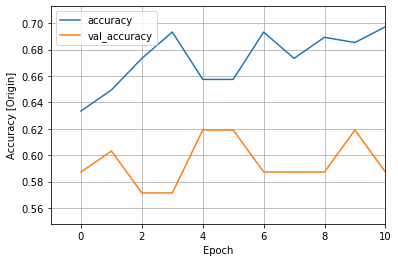

In [23]:
plot_accuracy(history)

In [24]:
horsepower_model.evaluate(test_features['Horsepower'], test_labels)

3/3 [==============================] - 0s 1ms/step - loss: 0.7605 - categorical_accuracy: 0.6667


[0.7605146169662476, 0.6666666865348816]

In [26]:
horsepower_model.predict(test_features['Horsepower'].iloc[:5])

array([[0.997, 0.001, 0.002],
       [0.999, 0.   , 0.001],
       [0.997, 0.001, 0.002],
       [0.614, 0.184, 0.202],
       [0.679, 0.15 , 0.171]], dtype=float32)

In [27]:
test_labels.head()

,USA,Europe,Japan
9,1,0,0
25,1,0,0
28,1,0,0
31,0,0,1
33,1,0,0
